# Query for Spectraction Results in OGA

 work with Weakly_2023_35
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/09/14
- last update : 2023/09/14

- Spectractor https://github.com/lsst/Spectractor/
- Spectractor Version 2.5


Implement

- add exposure info in hdf5 attribute to get azimuth



In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_35/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_35/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_35/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+c55b99ec95 	current w_2023_35 setup


In [3]:
import h5py

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
from astropy.time import Time
import astropy.units as u

## Config

In [7]:
FLAG_MOUNT_ERRORS= False

### Butler

In [8]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
#repo = "/repo/embargo/"
butler = dafButler.Butler(repo)
registry = butler.registry

## User collections

In [9]:
DateToRuncollection_emptyholo4003_rebin2 = {

# September 2023    
  20230912 : 'u/dagoret/spectro/emptyholo4003noflat/runs_20230912',
  20230913 : 'u/dagoret/spectro/emptyholo4003noflat/runs_20230913',
    
}

DateToRuncollection_emptyholo4001_rebin2 = {

# September 2023    
  20230912 : 'u/dagoret/spectro/emptyholo4001noflat/runs_20230912',
  20230913 : 'u/dagoret/spectro/emptyholo4001noflat/runs_20230913',
    
}


DateToRuncollection_collimatorholo4003_rebin2 = {
    20230912 : 'u/dagoret/spectro/collimatorholo4003noflat/runs_20230912',
    20230913 : 'u/dagoret/spectro/collimatorholo4003noflat/runs_20230913',
}

## Working mode

### Date

In [10]:
MODE_REBIN = 2
DATE = 20230913
#filterdispersername = "empty~holo4_003"
filterdispersername = "empty~holo4_001"
#filterdispersername = "collimator~holo4_003"

if MODE_REBIN == 2 and filterdispersername == "empty~holo4_003":
    my_collection = DateToRuncollection_emptyholo4003_rebin2[DATE]
elif MODE_REBIN == 2 and filterdispersername == "empty~holo4_001":
    my_collection = DateToRuncollection_emptyholo4001_rebin2[DATE]
elif MODE_REBIN == 2 and filterdispersername == "collimator~holo4_003":
    my_collection = DateToRuncollection_collimatorholo4003_rebin2[DATE]
else:
    my_collection = None



## Output path at USDF

In [11]:
output_path = "/home/d/dagoret/rubin-user/DATA/AuxtelData2023/ExtractedSpectra/2023-09"
output_path = "."

# List of Dataset types avalaible in my collection

## List of dataset types

In [12]:
list(registry.queryDatasetTypes("*spec*"))

[DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict),
 DatasetType('spectraction', {band, instrument, detector, physical_filter, visit}, Spectraction),
 DatasetType('spectractorImage', {band, instrument, detector, physical_filter, visit}, SpectractorImage),
 DatasetType('spectractorSpectrum', {band, instrument, detector, physical_filter, visit}, SpectractorSpectrum),
 DatasetType('spectrogramLibradtranFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters),
 DatasetType('spectrumForwardModelFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters),
 DatasetType('spectrumLibradtranFitParameters', {band, instrument, detector, physical_filter, visit}, SpectractorFitParameters)]

## list of datasets

In [13]:
list(registry.queryDatasets("*spec*", collections=[my_collection]))[:10]

[DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023091300327, ...}, run='u/dagoret/spectro/emptyholo4001noflat/runs_20230913/20230914T192833Z', id=ec1f46cb-1aa0-4082-abba-ad1942bbb446),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023091300303, ...}, run='u/dagoret/spectro/emptyholo4001noflat/runs_20230913/20230914T192833Z', id=2337f2a4-32a7-4c8a-a858-65431f047d5a),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit}, StructuredDataDict), {instrument: 'LATISS', detector: 0, visit: 2023091300363, ...}, run='u/dagoret/spectro/emptyholo4001noflat/runs_20230913/20230914T192833Z', id=6e817543-e384-431a-ac70-61c44639339b),
 DatasetRef(DatasetType('atmospecCentroid', {band, instrument, detector, physical_filter, visit},

In [14]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  seq_start: int
  seq_end: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  timespan: lsst.daf.butler.Timespan


In [15]:
#where_clause = f"instrument=\'LATISS\' AND exposure.day_obs={DATE} AND exposure.science_program=\'spec\'"
where_clause = f"instrument=\'LATISS\' AND exposure.day_obs={DATE} AND exposure.science_program=\'SITCOM-1001\'"


In [16]:
where_clause

"instrument='LATISS' AND exposure.day_obs=20230913 AND exposure.science_program='SITCOM-1001'"

In [17]:
results_exposures = registry.queryDimensionRecords('exposure',datasets="raw",collections = 'LATISS/raw/all',where=where_clause)

In [18]:
#results_exposures = registry.queryDimensionRecords('exposure',datasets="raw",collections = 'LATISS/raw/all',where= "instrument='LATISS' AND exposure.day_obs=20230718 AND exposure.science_program='spec'")

In [19]:
list_exposures_attrib = list(results_exposures)
dict_exposure = {}
for element in list_exposures_attrib:
    element_id = element.id
    #print(f'--------- {element_id} -------')
    #print(element.toDict())
    dict_exposure[element_id] = element

In [20]:
#dict_exposure

### Spectractor

In [21]:
if MODE_REBIN == 2:
    configmode = "PSF2DFFM_REBIN2"
else:
    configmode = "PSF2DFFM_REBIN1"

specver="specV2.5"

https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

In [22]:
#summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.csv"
output_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.hdf5"

In [23]:
fullpath_output_file_h5 = os.path.join(output_path,output_file_h5)
fullpath_summary_file = os.path.join(output_path,summary_file)

### The collection

In [24]:
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [25]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

In [26]:
if FLAG_MOUNT_ERRORS:
    df_mounterrors = pd.read_csv("mountErrors.csv")
    df=df_mounterrors[df_mounterrors["date_obs"] == DATE ]
    if len(df) == 0:
        FLAG_MOUNT_ERRORS = False
        

## Loop on exposures

In [27]:
#outfile.close()

In [28]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers
all_h5group = []

#hf_outfile =  h5py.File(output_file_h5, 'w')
hf_outfile =  h5py.File(fullpath_output_file_h5, 'w') 
  

for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    
    #through old runs
    date_of_run = int(ref.run.split("/")[-1].split("T")[0])
    
 
    
    
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    
    #print(dict_exposure[the_exposure])
    
    the_exposure_key = str(the_exposure)
    
    if the_exposure not in all_exposures:
        g = hf_outfile.create_group(the_exposure_key)
        all_h5group.append(g) 
    else:
        print(f">>>>>>  already existing key {the_exposure_key} Skip it !!! ")
        the_exposure_key = the_exposure_key + "_b"
        continue
   
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectractorSpectrum', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    

============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_001', visit: 2023091300327}
visit...................: 2023091300327
band....................: white
physical filter.........: empty~holo4_001
run.....................: u/dagoret/spectro/emptyholo4001noflat/runs_20230913/20230914T192833Z
{'day_obs': 20230913, 'seq_num': 327, 'detector': 0}
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_001', visit: 2023091300303}
visit...................: 2023091300303
band....................: white
physical filter.........: empty~holo4_001
run.....................: u/dagoret/spectro/emptyholo4001noflat/runs_20230913/20230914T192833Z
{'day_obs': 20230913, 'seq_num': 303, 'detector': 0}


In [29]:
hf_outfile.keys()

<KeysViewHDF5 ['2023091300303', '2023091300327']>

In [30]:
index = 0

spec = all_spec[index]

In [31]:
the_h5group = all_h5group[index] 

In [32]:
d = the_h5group.create_dataset('airmass', data=spec.airmass)

In [33]:
spec.airmass

1.09019897634712

In [34]:
spec.date_obs

'2023-09-14T04:06:06.138002232Z'

In [35]:
spec.cov_matrix.shape

(1158, 1158)

In [36]:
spec.lambdas.shape

(1158,)

In [37]:
spec.data_next_order.shape

(1158,)

In [38]:
#spec.chromatic_psf.load_table()
spec.chromatic_psf.table

lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
301.6182008741466,426.7253912901959,1.3628000368387916,-8.120398864461865,-0.15797410384046628,1.0,6.399119756326965,6.312313598972025,-6.757604571411876,-14.117337980964432,1.0,0.09666504486165195,37.86945355207649,5.335140629879401,2.3097859155220943,22666.666666666682
302.3245729722802,427.7253912901959,1.357190369117248,-8.139428449746324,-5.170817702827227,1.0,6.392765419304219,6.3104165175926,-6.776634840422616,-14.1306140756917,1.0,1.0959379635269784,37.87748217089121,5.332376084340705,2.3102407576287995,22666.666666666682
303.03093777055193,428.7253912901959,1.3515907707529635,-8.15845803503089,16.46103127270867,1.0,6.384473397763709,6.304498223795434,-6.795670898901178,-14.14389595988679,1.0,2.095216804611084,37.885238681071044,5.329610658095019,2.3106930645476704,22666.666666666682
303.73729520305176,429.7253912901959,1.346001241745924,-8.177487620315562,-3.867596129492535,1.0,6.3818257688342035,6.3010464758520754,-6.814712716876198,-14.157183663521057,1.0,3.0945015011373584,37.89272627379272,5.3268443511423405,2.3111428362787083,22666.666666666682
304.4436452044641,430.7253912901959,1.3404217820961435,-8.19651720560034,-3.748653778470333,1.0,6.3721159636360625,6.298126274298852,-6.833748785345222,-14.170488695596909,1.0,4.093791987113491,37.899948093319324,5.32407716348267,2.311590072821912,22666.666666666682
305.1499877100632,431.7253912901959,1.334852391803608,-8.215546790885222,11.241434572574319,1.0,6.373242927164573,6.292972634695516,-6.8527906432820505,-14.183799517140564,1.0,5.093088197524878,37.90690723733974,5.321309095116009,2.3120347741772824,22666.666666666682
305.8563226556953,432.7253912901959,1.3292930708683173,-8.234576376170207,6.322368125015918,1.0,6.340900921029373,6.288069686261878,-6.871837259931753,-14.197117158906991,1.0,6.0923900683037004,37.913606758431555,5.3185401460423565,2.312476940344819,22666.666666666682
306.56264997777384,433.7253912901959,1.3237438192902857,-8.253605961455296,-12.900369491235558,1.0,6.320535332469621,6.286511999323807,-6.890691761099095,-14.21063849509139,1.0,7.091697536322158,37.920049664400594,5.3157703162617125,2.312916571324522,22666.666666666682
307.2689696132631,434.7253912901959,1.3182046370695133,-8.272635546740489,-13.953386285186403,1.0,6.307293491505966,6.282629582701077,-6.909552051734245,-14.224165620743593,1.0,8.091010539363822,37.926238919586964,5.312999605774077,2.3133536671163917,22666.666666666682


In [39]:
spec.spectrogram_saturation

22666.666666666668

In [40]:
spec.chromatic_psf.plot_summary()

In [41]:
def DumpSpectrum(spec):
    print("--------------------------------------------")
    print("spec.target.label\t",spec.target.label)
    print("spec.filter_label\t",spec.filter_label)
    print("spec.airmass\t",spec.airmass)
    print("spec.date_obs\t",spec.date_obs)
    print("spec.temperature\t",spec.temperature)
    print("spec.pressure\t",spec.pressure)
    print("spec.humidity\t",spec.humidity)    
    #print("spec.ra\t",spec.ra)
    print("spec.dec\t",spec.dec)
    print("spec.hour_angle\t",spec.hour_angle)
    print("spec.parallactic_angle\t",spec.parallactic_angle)
    print("spec.camera_angle\t", spec.camera_angle)
    print("--------------------------------------------")
    print("spec.order\t",spec.order)
    print("spec.lambdas\t",spec.lambdas)
    print("spec.data\t",spec.data)
    print("spec.err\t",spec.err)
    print("spec.covmatrix\t",spec.cov_matrix)
    print("--------------------------------------------")
    print("spec.data_next_order\t",spec.data_next_order)
    print("spec.err_next_order\t",spec.err_next_order)

In [42]:
def AddDataSetsInGroup(spec,h5group):
  
    #spectrum

    h5group.attrs['spec_target_label'] = spec.target.label
    h5group.attrs['spec_filter_label'] = spec.filter_label
    h5group.attrs["spec_date_obs"] = spec.date_obs
    h5group.attrs["spec_airmass"] = spec.airmass 
    h5group.attrs["spec_temperature"] = spec.temperature
    h5group.attrs["spec_pressure"] = spec.pressure
    h5group.attrs["spec_humidity"] = spec.humidity
    h5group.attrs["spec_dec"] = spec.dec
    h5group.attrs["spec_hour_angle"] = spec.hour_angle
    h5group.attrs["spec_parallactic_angle"] = spec.parallactic_angle
    h5group.attrs["spec_camera_angle"] = spec.camera_angle
    h5group.attrs["spec_order"] = spec.order
    
    
    d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opts=9)
    
    # spectrogram
    
    d = h5group.create_dataset("spec_spectrogram",data=spec.spectrogram,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_bgd",data=spec.spectrogram_bgd,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_bgd_rms",data=spec.spectrogram_bgd_rms,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_err",data=spec.spectrogram_err,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_residuals",data=spec.spectrogram_residuals,compression="gzip", compression_opts=9)
    d = h5group.create_dataset("spec_spectrogram_fit",data=spec.spectrogram_fit,compression="gzip", compression_opts=9)
    
    
    h5group.attrs["spec_spectrogram_x0"]=spec.spectrogram_x0
    h5group.attrs["spec_spectrogram_y0"]=spec.spectrogram_y0
    h5group.attrs["spec_spectrogram_xmin"]=spec.spectrogram_xmin
    h5group.attrs["spec_spectrogram_xmax"]=spec.spectrogram_xmax
    h5group.attrs["spec_spectrogram_ymin"]=spec.spectrogram_ymin
    h5group.attrs["spec_spectrogram_ymax"]=spec.spectrogram_ymax
    h5group.attrs["spec_spectrogram_deg"]=spec.spectrogram_deg
    h5group.attrs["spec_spectrogram_saturation"]=spec.spectrogram_saturation      
    h5group.attrs["spec_spectrogram_Nx"]=spec.spectrogram_Nx
    h5group.attrs["spec_spectrogram_Ny"]=spec.spectrogram_Ny
    
    
    # header
    
    h5group.attrs["spec_header_target"]=spec.header["TARGET"]
    h5group.attrs["spec_header_redshift"]=spec.header["REDSHIFT"]
    h5group.attrs['spec_header_grating']=spec.header["GRATING"]
    h5group.attrs["spec_header_rotangle"]=spec.header["ROTANGLE"]
    h5group.attrs["spec_header_d2ccd"]=spec.header["D2CCD"]
    h5group.attrs["spec_header_lshift"]=spec.header["LSHIFT"]
    h5group.attrs["spec_header_parangle"]=spec.header["PARANGLE"]
    h5group.attrs["spec_header_targetx"]=spec.header["TARGETX"]
    h5group.attrs["spec_header_targety"]=spec.header["TARGETY"]
    h5group.attrs["spec_header_lbda_ref"]=spec.header["LBDA_REF"]
    h5group.attrs["spec_header_pixshift"]=spec.header["PIXSHIFT"]
    h5group.attrs["spec_header_psf_reg"]=spec.header["PSF_REG"]
    h5group.attrs["spec_header_trace_r"]=spec.header["TRACE_R"]   
    h5group.attrs["spec_header_chi2_fit"]=spec.header["CHI2_FIT"]   
    h5group.attrs["spec_header_a2_fit"]=spec.header["A2_FIT"]
    h5group.attrs["spec_header_am_fit"]=spec.header["AM_FIT"]
    h5group.attrs["spec_header_meanfwhm"]=spec.header["MEANFWHM"]
    h5group.attrs["spec_header_version"]=spec.header["VERSION"]
    h5group.attrs["spec_header_rebin"]=spec.header["REBIN"]
    h5group.attrs['spec_header_date-obs']=spec.header["DATE-OBS"]
    h5group.attrs["spec_header_exptime"]=spec.header["EXPTIME"]
    h5group.attrs["spec_header_airmass"]=spec.header["AIRMASS"] 
    h5group.attrs["spec_header_dec"]=spec.header["DEC"]
    h5group.attrs["spec_header_ha"]=spec.header["HA"]
    h5group.attrs["spec_header_outtemp"]=spec.header["OUTTEMP"] 
    h5group.attrs["spec_header_outpress"]=spec.header["OUTPRESS"] 
    h5group.attrs["spec_header_outhum"]=spec.header["OUTHUM"]
    h5group.attrs["spec_header_filter"]=spec.header["FILTER"]
    h5group.attrs["spec_header_cam_rot"]=spec.header["CAM_ROT"] 
    h5group.attrs["spec_header_s_x0"]=spec.header["S_X0"]
    h5group.attrs["spec_header_s_y0"]=spec.header["S_Y0"]
    h5group.attrs["spec_header_s_xmin"]=spec.header["S_XMIN"]      
    h5group.attrs["spec_header_s_xmax"]=spec.header["S_XMAX"]                                               
    h5group.attrs["spec_header_s_ymin"]=spec.header["S_YMIN"]      
    h5group.attrs["spec_header_s_ymax"]=spec.header["S_YMAX"]                                                                                                                  
    h5group.attrs["spec_header_s_nx"]=spec.header["S_NX"]
    h5group.attrs["spec_header_s_ny"]=spec.header["S_NY"]   
    h5group.attrs["spec_header_s_dec"]=spec.header["S_DEG"]  
    h5group.attrs["spec_header_s_sat"]=spec.header["S_SAT"]      
                                               
    

In [43]:
def AddMountErrorsInGroup(h5group,az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms):
    h5group.attrs["me_az_rms"]=az_rms
    h5group.attrs["me_el_rms"]=el_rms
    h5group.attrs["me_rot_rms"]=rot_rms
    h5group.attrs["me_image_az_rms"]=image_az_rms
    h5group.attrs["me_image_el_rms"]=image_el_rms
    h5group.attrs["me_image_rot_rms"]=image_rot_rms
        

In [44]:
def AddExposureInfoInGroup(expoinfo,h5group):
    """
    Add the following informations to hdf5
    {'instrument': 'LATISS', 
     'id': 2023072000256, 
     'physical_filter': 'empty~holo4_003', 
     'obs_id': 'AT_O_20230720_000256', 
     'exposure_time': 30.0, 
     'dark_time': 30.2367, 
     'observation_type': 'science', 
     'observation_reason': 'generic', 
     'day_obs': 20230720, 
     'seq_num': 256, 
     'seq_start': 256, 
     'seq_end': 256, 
     'group_name': '2023-07-21T02:37:11.700', 
     'group_id': 2698366317000000, 
     'target_name': 'HD185975', 
     'science_program': 'spec', 
     'tracking_ra': 307.76950795132393, 
     'tracking_dec': -87.4337852028312, 
     'sky_angle': 42.62309278535102, 
     'azimuth': 177.85543058634352, 
     'zenith_angle': 57.826045218956686, 
     'has_simulated': False, 
     'timespan': Timespan(begin=astropy.time.Time('2023-07-21 02:37:47.189004', scale='tai', format='iso'), end=astropy.time.Time('2023-07-21 02:38:17.426000', scale='tai', format='iso'))
     }
    """
    h5group.attrs["expo_instrument"] = expoinfo.instrument
    h5group.attrs["expo_id"] = expoinfo.id
    h5group.attrs["physical_filter"] = expoinfo.physical_filter
    h5group.attrs["obs_id"] = expoinfo.obs_id
    h5group.attrs["exposure_time"] = expoinfo.exposure_time
    h5group.attrs["dark_time"] = expoinfo.dark_time
    h5group.attrs["observation_type"] = expoinfo.observation_type
    h5group.attrs["observation_reason"] = expoinfo.observation_reason
    h5group.attrs["day_obs"] = expoinfo.day_obs    
    h5group.attrs["seq_num"] = expoinfo.seq_num
    h5group.attrs["group_name"] = expoinfo.group_name
    h5group.attrs["group_id"] = expoinfo.group_id
    h5group.attrs["target_name"] = expoinfo.target_name
    h5group.attrs["science_program"] = expoinfo.science_program
    h5group.attrs["tracking_ra"] = expoinfo.tracking_ra
    h5group.attrs["tracking_dec"] = expoinfo.tracking_dec
    h5group.attrs["sky_angle"] = expoinfo.sky_angle
    h5group.attrs["azimuth"] = expoinfo.azimuth
    h5group.attrs["zenith_angle"] = expoinfo.zenith_angle
    h5group.attrs["mjd"] = Time(expoinfo.timespan.begin.to_string()).mjd
    h5group.attrs["jd"] = Time(expoinfo.timespan.begin.to_string()).jd

    
   

In [45]:
def AddDataSetsInGroupAndIndexExposure(spec,h5group,index,exposure,expoinfo):

    h5group.attrs["index"]=index
    h5group.attrs["exposure"]=exposure
    
    AddDataSetsInGroup(spec,h5group)
    AddExposureInfoInGroup(expoinfo,h5group)

In [46]:
DumpSpectrum(spec)

--------------------------------------------
spec.target.label	 HD2811
spec.filter_label	 empty
spec.airmass	 1.09019897634712
spec.date_obs	 2023-09-14T04:06:06.138002232Z
spec.temperature	 7.02500009536743
spec.pressure	 743
spec.humidity	 14.9499998092651
spec.dec	 -43.5712848932648
spec.hour_angle	 -24.497100130526373
spec.parallactic_angle	 -63.71726122904709
spec.camera_angle	 243.8991028055464
--------------------------------------------
spec.order	 1
spec.lambdas	 [ 302.65769985  303.36489814  304.07208868 ... 1106.21171982 1106.89039133
 1107.56902468]
spec.data	 [-5.61217288e-15 -4.64654778e-15  1.49005067e-15 ...  3.46297317e-14
  4.09000582e-14  4.34742281e-14]
spec.err	 [1.91638271e-15 1.17566036e-15 1.08611660e-15 ... 3.08043690e-15
 3.89851310e-15 5.19287216e-15]
spec.covmatrix	 [[ 3.67252268e-30  3.99172812e-31 -7.38602717e-31 ...  2.28259074e-32
  -2.53302881e-32 -3.65532333e-32]
 [ 3.99172812e-31  1.38217729e-30  8.30463967e-33 ...  6.28195328e-33
   2.77696289e-32  2

# Save all spectra in a single file

In [47]:
exposures_sorted = np.sort(all_exposures)

In [48]:
for idx,spec in enumerate(all_spec):   
    the_exposure = all_exposures[idx]
    the_sorted_index = np.where(exposures_sorted == the_exposure)[0][0]
    
    
    #print(dict_exposure[the_exposure])
    
    # here add in HDF5
    AddDataSetsInGroupAndIndexExposure(spec,all_h5group[idx],the_sorted_index,the_exposure,dict_exposure[the_exposure])
    
    
    if FLAG_MOUNT_ERRORS:
        df_exp_selected = df[df["exposure"] == the_exposure]
        N = len(df_exp_selected)
        if (N)>0:
            az_rms = df_exp_selected["az_rms"].values[0]
            el_rms = df_exp_selected["el_rms"].values[0]
            rot_rms = df_exp_selected["rot_rms"].values[0]
            image_az_rms = df_exp_selected["image_az_rms"].values[0]
            image_el_rms = df_exp_selected["image_el_rms"].values[0]
            image_rot_rms = df_exp_selected["image_rot_rms"].values[0]
            AddMountErrorsInGroup(all_h5group[idx],az_rms,el_rms,rot_rms,image_az_rms,image_el_rms,image_rot_rms)
        else:
            print(f"No error mount for exposure {the_exposure}")
            AddMountErrorsInGroup(all_h5group[idx],-1.,-1.,-1.,-1.,-1.,-1.)
            

In [49]:
hf_outfile.keys()

<KeysViewHDF5 ['2023091300303', '2023091300327']>

In [50]:
#AddDataSetsInGroup(spec,the_h5group) # already done previously
hf_outfile.close() 

## Plot Spectra

- sequence order

In [51]:
rank = np.argsort(all_exposures)

In [52]:
NSPEC = len(all_exposures)

In [53]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

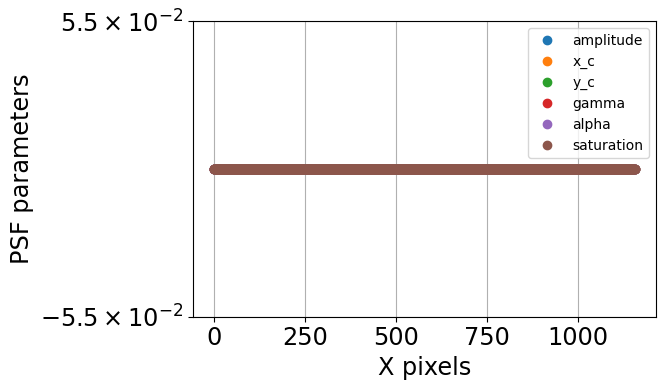

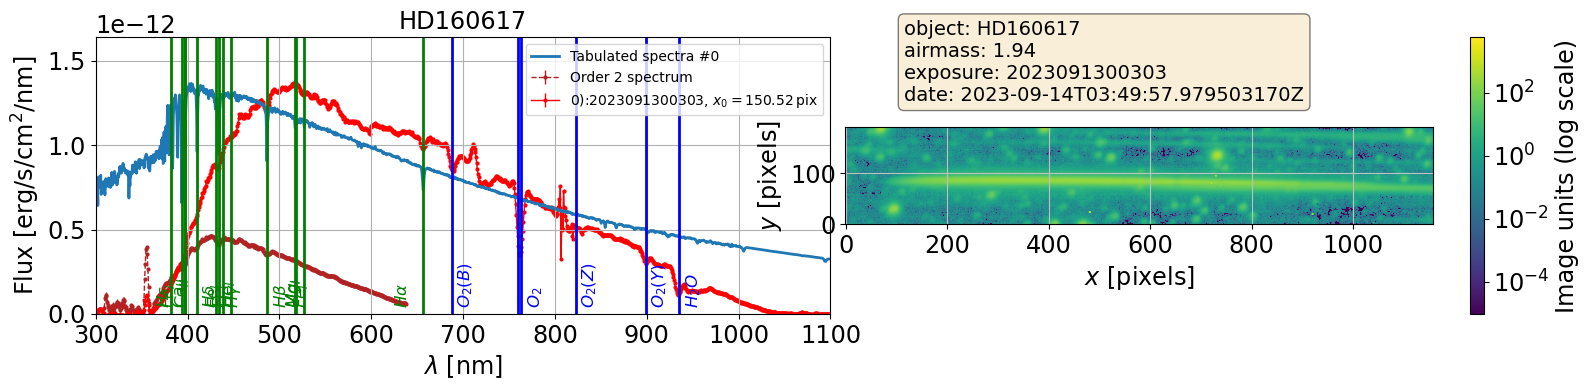

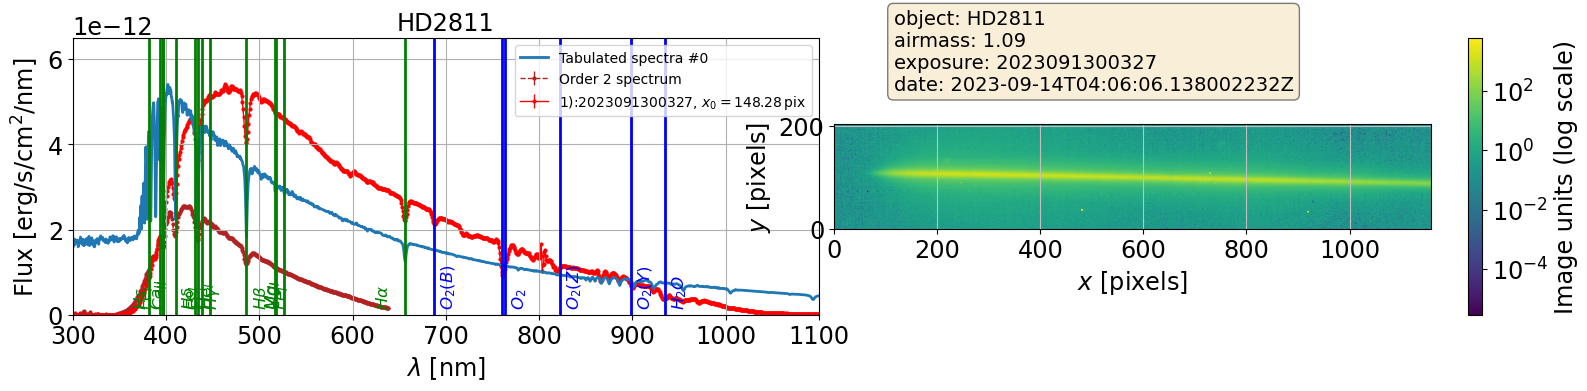

In [54]:
%matplotlib inline

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]
all_textstr = []



# loop on spectra
for index in range(NSPEC):
    
    idx = rank[index]
    s=all_spec[idx]
    label = str(index) +"):" + str(all_exposures[idx])
    the_expos = all_exposures[idx]
    
    try:
        fig=plt.figure(figsize=(16,4))
        
       
        textstr = '\n'.join((f"object: {s.target.label}", f"airmass: {s.airmass:.2f}",f"exposure: {the_expos}",f"date: {s.date_obs}"))
    
        ax1 = fig.add_subplot(1, 2, 1)
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        ax2 = fig.add_subplot(1, 2, 2)
        s.plot_spectrogram(ax=ax2,scale="log")
        ax2.text(0.1, 2.1, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        #save info    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
        all_textstr.append(textstr)
        
        
            
    except Exception as inst:
        print(" >>> Exception catched for "+ label )
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args

    
    idx+=1

# Save plot in pdf file

In [55]:
from matplotlib.backends.backend_pdf import PdfPages

In [56]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_spec)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    # loop on spectra
    for index in range(Nspec):  
        
        # get index on spectrum
        idx = rank[index]
        textstr = all_textstr[index]
   
        # if we need to start a new page
        if idx_inpage == nbspecperpage:
            idx_inpage = 1  # start at the first row in the page from 1 to nbspecperpage
            idx_pagenum += 1  # increase page counter
            
            # this trigger the saving of the whole figure (including all spectra of the page)
            if idx_pagenum > 1:
                plt.show()
                all_composed_figs.append(fig)
            
            # this create a new figure 
            fig=plt.figure(figsize=(16,20))
            
        # this is not a new page, need to increase the row number inside this page from 1 to nbspecperpage    
        else:
            idx_inpage += 1   
        
        # index of the figure in the page
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {index}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
    
        # Get the spectrum          
        s=all_spec[idx]
        label = str(index) +"):" + str(all_exposures[idx])
        
        # left image, two columns
        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        #right image, to columns
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
        s.plot_spectrogram(ax=ax2,scale="log")
        ax2.text(0.1, 2.1, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        
             
                           
    return  all_composed_figs
    


	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/1.0, idx_inpage = 1, idx_fig = 1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/1.0, idx_inpage = 2, idx_fig = 3


/home/d/dagoret/repos/repos_w_2023_35/Spectractor/lib/python/spectractor/extractor/spectrum.py:436: UserWarning: The figure layout has changed to tight
  plt.gcf().tight_layout()


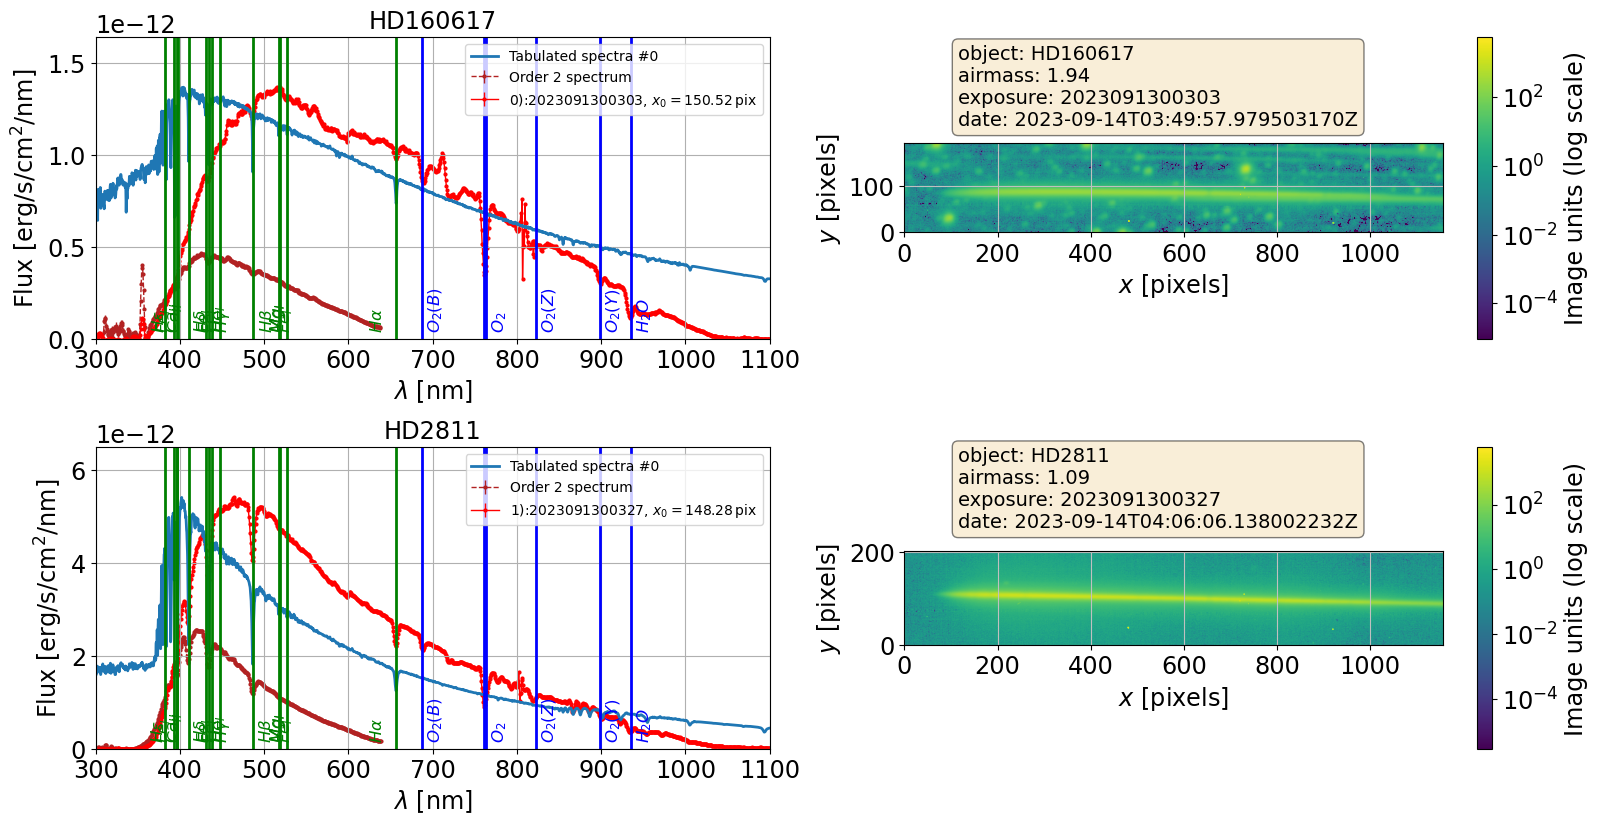

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

In [58]:
multipage_pdf_file = f'multipage_pdf_spectra_holo_{DATE}-{filterdispersername}-{configmode}-{specver}.pdf'

In [59]:
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()